In [1]:
import pandas as pd
import re #To apply regex while converting the genres which is in string format to a list
import numpy as np #Used for np.where()
import itertools #Used for itertools.chain.from_iterable() [See below for explanation]

from sklearn.feature_extraction.text import TfidfVectorizer #Used for TfidfVectorizer(), fit_transform() [Explanation below]
from sklearn.preprocessing import MinMaxScaler #Used for MinMaxScaler(). [Explanation below]
from sklearn.metrics.pairwise import cosine_similarity

#For using and connecting to Spotify API

!pip install spotipy 

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import sys
import json
import warnings
warnings.filterwarnings("ignore")




In [2]:
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None) 

In [3]:
from os import getcwd
getcwd()

'C:\\Users\\Srushti'

In [4]:
from os import chdir
chdir('C:\\Users\Srushti\Desktop\Spotify')

In [5]:
from os import getcwd
getcwd()

'C:\\Users\\Srushti\\Desktop\\Spotify'

#                               Data Preparation / Data Cleaning






In [6]:
spotify_df = pd.read_csv('data.csv')

In [7]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [8]:
spotify_df.dtypes

valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object

  Observations:





1.   Release date will useful but I'll need to create a one hot encoded variable for release date in 5 year increments
2.   Similarly, I'll need to create one hot encoded variables for the popularity with 5 year increments




In [9]:
data_w_genre = pd.read_csv('data_w_genres.csv')

In [10]:
data_w_genre.head(20)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7
5,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.609556,0.487278,205091.944444,0.309906,0.004696,0.274767,-18.266389,0.098022,118.648944,0.441556,32.777778,5,1,36
6,[],"""Mama"" Helen Teagarden",0.725000,0.637000,135533.000000,0.512000,0.186000,0.426000,-20.615000,0.210000,134.819000,0.885000,0.000000,8,1,2
7,[],"""Test for Victor Young""",0.927000,0.734000,175693.000000,0.474000,0.076200,0.737000,-10.544000,0.256000,132.788000,0.902000,3.000000,10,1,2
8,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.000050,0.161102,-9.768705,0.084536,133.031180,0.751344,34.229508,9,1,122
9,"['emo rap', 'florida rap', 'sad rap', 'undergr...",$NOT,0.544467,0.789800,137910.466667,0.532933,0.023063,0.180300,-9.149267,0.293687,112.344800,0.480700,67.533333,1,1,15


In [11]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [12]:
#To check if genres column is actually a list or not? It is not a list.
data_w_genre['genres'].values[0][0]

'['

In [13]:
#As we can see, it's actually a string that looks like a list. Now, I'm going to put together a regex statement to extract the genre and input into a list
data_w_genre['genres_updated'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])


Notes for the above regex statement:


1.   re.sub(pattern,replace with)
2.   re.findall(pattern,string)
3.   In regex, ^ = start of a string, * = Zero or more of the preceding character (eg. ca*t = cat, ct, caaaaaaaaaaaat)



In [14]:
data_w_genre['genres_updated'].head(15)

0                                          [show_tunes]
1                                                    []
2                                                    []
3                                                    []
4                                                    []
5                                                    []
6                                                    []
7                                                    []
8                          [comedy_rock, comic, parody]
9     [emo_rap, florida_rap, sad_rap, underground_hi...
10                                [dark_trap, meme_rap]
11                                                   []
12    [asian_american_hip_hop, cali_rap, west_coast_...
13    [dark_trap, new_orleans_rap, underground_hip_hop]
14                               [broadway, show_tunes]
Name: genres_updated, dtype: object

In [15]:
#Hence genres column is converted from string to list format ie. genres_updated column is the new column 
data_w_genre['genres_updated'].values[0][0]

'show_tunes'

In [16]:
data_w_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_updated
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9,[show_tunes]
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26,[]
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7,[]
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27,[]
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7,[]


In [17]:

spotify_df.dtypes

valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object

In [18]:
#Similarly now we will check if artists column in spotify_df is actually a list or not ? It is not, so will convert it into the list.
spotify_df['artists'].values[0][0]

'['

In [19]:
#Converting the artists column of spotify_df to list using regex statements
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [20]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"[Sergei Rachmaninoff, James Levine, Berliner P..."
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,[Dennis Day]
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,[KHP Kridhamardawa Karaton Ngayogyakarta Hadin...
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,[Frank Parker]
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,[Phil Regan]


In [21]:
spotify_df['artists_upd_v1'].values[0][0]

'Sergei Rachmaninoff'

In [22]:
# But this regex didn't catch all of them (compare the artists column and artists_upd_v1 col) 
#because artists with an apostrophe in their title and they are enclosed in a full quotes
# artists_upd_v1 has null values for the corresponding artists with apostrophe in their title
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1
143,0.300,1921,0.772,"[""Scarlet D'Carpio""]",0.560,249370,0.313,0,7b4eHImKQ51DYaQvNTdtEp,0.000005,6,0.115,-8.346,0,Himno Nacional del Perú,0,1921-09-23,0.0376,107.501,[]
234,0.902,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.708,194533,0.361,0,1xEEYhWxT4WhDQdxfPCT8D,0.883000,0,0.103,-11.764,0,Snake Rag,20,1923,0.0441,105.695,[]
238,0.554,1923,0.996,"[""King Oliver's Creole Jazz Band""]",0.546,170827,0.189,0,3rauXVLOOM5BlxWqUcDpkg,0.908000,0,0.339,-15.984,1,Chimes Blues,13,1923,0.0581,80.318,[]
244,0.319,1923,0.995,"[""Clarence Williams' Blue Five""]",0.520,197493,0.153,0,1UdqHVRFYMZKU2Q7xkLtYc,0.131000,0,0.353,-14.042,1,Pickin' On Your Baby,11,1923,0.0440,102.937,[]
249,0.753,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.359,187227,0.357,0,5SvyP1ZeJX1jA7AOZD08NA,0.819000,3,0.290,-11.810,1,Tears,10,1923,0.0511,205.053,[]


In [23]:
#So now we write new regex to solve this problem
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))

In [24]:
#Checking if new regex worked with the new column artists_upd_v2
#Here the artists col contain name with apostrophe, artists_upd_v1 contain name in list format implemented with old regex 
#and artists_upd_v2 contain name with apostrophe in list format implemented with new regex 
spotify_df[spotify_df['id']=='7b4eHImKQ51DYaQvNTdtEp']

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2
143,0.3,1921,0.772,"[""Scarlet D'Carpio""]",0.56,249370,0.313,0,7b4eHImKQ51DYaQvNTdtEp,0.000005,6,0.115,-8.346,0,Himno Nacional del Perú,0,1921-09-23,0.0376,107.501,[],[Scarlet D'Carpio]


In [25]:
#Now combining the all the version of artists column into one artists_upd column 
#np.where(condition,if true execute this statement,if false execute this statement)
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x),spotify_df['artists_upd_v2'],spotify_df['artists_upd_v1'])


In [26]:
#Checking after combining all the version (selecting the 2 id one contains artists name with apostrophe and other not)
spotify_df[(spotify_df['id']=='7b4eHImKQ51DYaQvNTdtEp') |  (spotify_df['id']== '7xPhfUan2yNtyFG0cUWkt8')]

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd
1,0.963,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,[Dennis Day],[],[Dennis Day]
143,0.300,1921,0.772,"[""Scarlet D'Carpio""]",0.560,249370,0.313,0,7b4eHImKQ51DYaQvNTdtEp,0.000005,6,0.115,-8.346,0,Himno Nacional del Perú,0,1921-09-23,0.0376,107.501,[],[Scarlet D'Carpio],[Scarlet D'Carpio]


In [27]:
dup = spotify_df[spotify_df.duplicated('name')]

In [28]:
#Here we can see how there are duplicates of the same song with different ids.
dup.sort_values('name').head(20)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd
85098,0.3100,1983,0.18500,['U2'],0.371,157667,0.5450,0,3vMmwsAiLDCfyc1jl76lQE,0.582000,8,0.1830,-9.315,1,"""40"" - Remastered 2008",35,1983-02-28,0.0307,150.316,[U2],[],[U2]
24090,0.3420,1946,0.94300,"['Georges Bizet', 'Jascha Heifetz', 'Donald Vo...",0.289,583573,0.1980,0,0xVbtHC4BM071oCAYrMxy1,0.376000,9,0.1940,-19.978,1,"""Carmen Fantasie"", by Franz Waxman, based on t...",0,1946,0.0539,70.255,"[Georges Bizet, Jascha Heifetz, Donald Voorhee...",[],"[Georges Bizet, Jascha Heifetz, Donald Voorhee..."
89666,0.6700,2007,0.00614,['Fall Out Boy'],0.609,213587,0.9170,0,4zCfMDdf5QXPKEqxdinXvB,0.000020,9,0.0775,-2.563,1,"""The Take Over, The Breaks Over""",52,2007-02-06,0.0477,149.948,[Fall Out Boy],[],[Fall Out Boy]
103528,0.0785,1994,0.99500,['Aphex Twin'],0.619,447800,0.0327,0,35NyjYJFaJxqbUF2y0jWl1,0.712000,10,0.0865,-20.273,0,#1,43,1994-03-07,0.0371,102.884,[Aphex Twin],[],[Aphex Twin]
154608,0.0524,2015,0.00591,"['$uicideBoy$', 'Pouya']",0.798,169169,0.5290,1,5NXeprz7VhJkG6RgSAqqeO,0.394000,1,0.0720,-6.327,1,$outh $ide $uicide,53,2015-09-01,0.0740,109.995,"[$uicideBoy$, Pouya]",[],"[$uicideBoy$, Pouya]"
124296,0.3460,2017,0.21300,"['Billie Eilish', 'Vince Staples']",0.776,179016,0.3790,0,6X7qcg95CAeJpTjtg1wooM,0.001750,9,0.0969,-9.351,0,&burn (with Vince Staples),63,2017-12-22,0.3310,82.531,"[Billie Eilish, Vince Staples]",[],"[Billie Eilish, Vince Staples]"
99766,0.3360,1975,0.02750,['Queen'],0.519,210800,0.5840,0,02MiyVckOBtygUOEDnV7Pd,0.000000,8,0.1110,-9.670,1,'39 - Remastered 2011,26,1975-11-21,0.0270,101.632,[Queen],[],[Queen]
88000,0.7430,1999,0.09490,['Eminem'],0.723,316413,0.9160,0,0PG5rPYaf19GiTf05urOBo,0.000405,9,0.2970,-6.526,0,'97 Bonnie & Clyde,48,1999-02-23,0.5170,184.083,[Eminem],[],[Eminem]
132704,0.0848,1979,0.94900,"['Francesco Paolo Tosti', 'Luciano Pavarotti',...",0.139,188547,0.1060,0,1NZJULt4LISYlQShksvZGr,0.005330,5,0.0732,-21.215,1,'A vucchella,32,1979-01-01,0.0405,81.090,"[Francesco Paolo Tosti, Luciano Pavarotti, Orc...",[],"[Francesco Paolo Tosti, Luciano Pavarotti, Orc..."
98797,0.6520,1970,0.95700,['Johnny Cash'],0.463,104800,0.1840,0,4ZlZMTYO7oTv8DWlA20Z2j,0.000007,7,0.1170,-14.363,1,'Cause I Love You,28,1970-11-11,0.1140,175.967,[Johnny Cash],[],[Johnny Cash]


In [29]:
#need to create a song identifier since there are duplicates of the same song with different ids.
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [30]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,"[Sergei Rachmaninoff, James Levine, Berliner P...",[],"[Sergei Rachmaninoff, James Levine, Berliner P...",Sergei RachmaninoffPiano Concerto No. 3 in D M...
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,[Dennis Day],[],[Dennis Day],Dennis DayClancy Lowered the Boom
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,[KHP Kridhamardawa Karaton Ngayogyakarta Hadin...,[],[KHP Kridhamardawa Karaton Ngayogyakarta Hadin...,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,[Frank Parker],[],[Frank Parker],Frank ParkerDanny Boy
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,[Phil Regan],[],[Phil Regan],Phil ReganWhen Irish Eyes Are Smiling


In [31]:
#Sorting the dataframe in ascending order
spotify_df.sort_values(['artists_song','release_date'], ascending = True, inplace = True)
#inplace = By default it is false. but if its value is true it performs operation in-place i.e. in proper place.

In [32]:
spotify_df.head(20)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
150996,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.4140,1,78859Af0fmA9VTlgnOHTAP,0.000110,4,0.1010,-8.450,0,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down"
103581,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.4900,0,3hoiinUc5VA9xUEJID7R8V,0.000170,9,0.1390,-9.504,0,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap"
15465,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.4590,1,6YYd5MLpu45J0uLrMdivF7,0.000000,1,0.2220,-7.654,1,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)"
16469,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.3870,1,4s0o8TJHfX9LLHa0umnOzT,0.000000,0,0.1310,-9.867,1,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)"
105644,0.819,2004,0.0218,"[""Lil' Flip"", 'Lea']",0.845,225187,0.3460,0,3FaUH7ZMjW1hv9Jx6MIAIf,0.000000,0,0.1350,-9.381,1,Sunshine (feat. Lea),47,2004-03-30,0.1060,93.989,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)"
15164,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.6930,0,2LP2uDQQ7eLMcUVE4aOpAV,0.000000,11,0.1230,-7.832,0,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R..."
34675,0.722,2000,0.0404,"[""Lil' Kim"", 'Sisqo']",0.584,233053,0.6820,1,5jv3QxL0MFswzM1UJ2qQJM,0.000000,10,0.3520,-9.597,0,How Many Licks? (feat. Sisqo),53,2000-06-16,0.3330,105.170,"[ Kim"", ]",[Lil' Kim],"[ Kim"", ]","Kim"", How Many Licks? (feat. Sisqo)"
33955,0.592,1997,0.0689,"[""Lil' Kim"", 'Angie Martinez', 'Lisa ""Left Eye...",0.854,252520,0.6020,0,42OhQBFNIbMyxRGxyPOvQA,0.000000,6,0.2920,-10.162,0,"Not Tonight (feat. Da Brat, Left Eye, Missy ""M...",53,1997-06-30,0.3200,99.429,"[ Kim"", , , , , , , ]","[Lil' Kim, Left Eye]","[ Kim"", , , , , , , ]","Kim"", Not Tonight (feat. Da Brat, Left Eye, M..."
35205,0.764,2003,0.0279,"[""Lil' Mo"", 'Fabolous']",0.683,222947,0.6570,0,6ubNZ5edKBKH3MQKatUY3S,0.000045,6,0.3670,-10.668,1,4Ever (feat. Fabolous),56,2003-02-11,0.0990,99.059,"[ Mo"", ]",[Lil' Mo],"[ Mo"", ]","Mo"", 4Ever (feat. Fabolous)"
103562,0.964,1994,0.4620,"[""Keb' Mo'""]",0.883,138427,0.4460,0,3xoMRK8egNvtjrCEQieLko,0.000001,0,0.0447,-10.304,1,Am I Wrong,44,1994,0.0574,112.635,[ Mo],[Keb' Mo'],[ Mo],MoAm I Wrong


In [33]:
#We see from the previous ouutput that there are many duplicates entry for the unique song identifier(artists_song), so we drop the duplicates
spotify_df.drop_duplicates('artists_song',inplace = True)

In [34]:
spotify_df.head(20)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
150996,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.4140,1,78859Af0fmA9VTlgnOHTAP,0.000110,4,0.1010,-8.450,0,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down"
103581,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.4900,0,3hoiinUc5VA9xUEJID7R8V,0.000170,9,0.1390,-9.504,0,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap"
15465,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.4590,1,6YYd5MLpu45J0uLrMdivF7,0.000000,1,0.2220,-7.654,1,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)"
16469,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.3870,1,4s0o8TJHfX9LLHa0umnOzT,0.000000,0,0.1310,-9.867,1,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)"
15164,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.6930,0,2LP2uDQQ7eLMcUVE4aOpAV,0.000000,11,0.1230,-7.832,0,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R..."
34675,0.722,2000,0.0404,"[""Lil' Kim"", 'Sisqo']",0.584,233053,0.6820,1,5jv3QxL0MFswzM1UJ2qQJM,0.000000,10,0.3520,-9.597,0,How Many Licks? (feat. Sisqo),53,2000-06-16,0.3330,105.170,"[ Kim"", ]",[Lil' Kim],"[ Kim"", ]","Kim"", How Many Licks? (feat. Sisqo)"
33955,0.592,1997,0.0689,"[""Lil' Kim"", 'Angie Martinez', 'Lisa ""Left Eye...",0.854,252520,0.6020,0,42OhQBFNIbMyxRGxyPOvQA,0.000000,6,0.2920,-10.162,0,"Not Tonight (feat. Da Brat, Left Eye, Missy ""M...",53,1997-06-30,0.3200,99.429,"[ Kim"", , , , , , , ]","[Lil' Kim, Left Eye]","[ Kim"", , , , , , , ]","Kim"", Not Tonight (feat. Da Brat, Left Eye, M..."
35205,0.764,2003,0.0279,"[""Lil' Mo"", 'Fabolous']",0.683,222947,0.6570,0,6ubNZ5edKBKH3MQKatUY3S,0.000045,6,0.3670,-10.668,1,4Ever (feat. Fabolous),56,2003-02-11,0.0990,99.059,"[ Mo"", ]",[Lil' Mo],"[ Mo"", ]","Mo"", 4Ever (feat. Fabolous)"
103562,0.964,1994,0.4620,"[""Keb' Mo'""]",0.883,138427,0.4460,0,3xoMRK8egNvtjrCEQieLko,0.000001,0,0.0447,-10.304,1,Am I Wrong,44,1994,0.0574,112.635,[ Mo],[Keb' Mo'],[ Mo],MoAm I Wrong
150541,0.306,1994,0.8310,"[""Keb' Mo'""]",0.644,179467,0.0768,0,6WmwvYaVSod4whIXGWEvBR,0.000031,6,0.0953,-13.348,1,Every Morning,37,1994-05-22,0.0424,78.719,[ Mo],[Keb' Mo'],[ Mo],MoEvery Morning


In [35]:
#Now explode artists_upd column in the spotify_df so each artist within a song will have their own row
artists_exploded_df = spotify_df[['artists_upd','id']].explode('artists_upd')

In [36]:
#Merging data_w_genre to the exploded dataset (artists_exploded_df) so that the exploded dataset is enriched with genre dataset
artists_exploded_upd = artists_exploded_df.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
#left_on = Column names to join on in the left DataFrame
#right_on = Column names to join on in the right DataFrame

In [37]:
artists_exploded_upd.head(70)

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_updated
0,"4-Tay"",",78859Af0fmA9VTlgnOHTAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,",",78859Af0fmA9VTlgnOHTAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Cru"", ""Michel",3hoiinUc5VA9xUEJID7R8V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Dirty Bastard"",",6YYd5MLpu45J0uLrMdivF7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,",",6YYd5MLpu45J0uLrMdivF7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Flip"",",4s0o8TJHfX9LLHa0umnOzT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"Kim"", ""Lil",2LP2uDQQ7eLMcUVE4aOpAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Kim"",",5jv3QxL0MFswzM1UJ2qQJM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"Kim"",",42OhQBFNIbMyxRGxyPOvQA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,",",42OhQBFNIbMyxRGxyPOvQA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Removing the null values from the artists_exploded_upd dataframe 
artists_exploded_nonnull = artists_exploded_upd[~artists_exploded_upd.genres_updated.isnull()]

In [39]:
artists_exploded_nonnull.head(10)

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_updated
62,"""Test for Victor Young""",6ivMXI6YMOPvsiUyTDIV7b,[],"""Test for Victor Young""",0.927000,0.734000,175693.000000,0.474000,0.07620,0.737000,-10.544000,0.256000,132.78800,0.902000,3.000000,10.0,1.0,2.0,[]
63,"""Weird Al"" Yankovic",2CstSu0GDI4dUFtE3VdubW,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
64,"""Weird Al"" Yankovic",1Yd0HypJ0bzilJS9MBztZZ,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
65,"""Weird Al"" Yankovic",2zMUYAHJfDU5MKqoCusTwo,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
66,"""Weird Al"" Yankovic",2Ec0liSMY2h4XORHyzKCmY,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
67,"""Weird Al"" Yankovic",5r96TaQquRrlo3Ym3ZlSL2,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
68,"""Weird Al"" Yankovic",23tktWr4FmFoJ6xEGqj3u2,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
69,"""Weird Al"" Yankovic",5plT9JEaW0ygCv4lDzqDFj,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
70,"""Weird Al"" Yankovic",1gloYGAZI6eHp6MEPjLuL3,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"
71,"""Weird Al"" Yankovic",79nOKa4cC3oMkzJT2kL0Jk,"['comedy rock', 'comic', 'parody']","""Weird Al"" Yankovic",0.173145,0.662787,218948.196721,0.695393,0.00005,0.161102,-9.768705,0.084536,133.03118,0.751344,34.229508,9.0,1.0,122.0,"[comedy_rock, comic, parody]"


In [40]:
#Now Group Rows on 'id' column and getting the list for 'genres_updated' column 
artists_genres_upd = artists_exploded_nonnull.groupby('id')['genres_updated'].apply(list).reset_index()

In [41]:
artists_genres_upd.head()

,id,genres_updated
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn..."
2,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]"
4,000jBcNljWTnyjB4YO7ojf,[[]]


In [42]:
#Now merging the lists into a one bracket list with unique values
artists_genres_upd['final_genre_lists'] = artists_genres_upd['genres_updated'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))
#from_iterable = chain.from_iterable(['geeks','for','geeks']) 
#print(list(from_iterable)) OUTPUT-> [‘g’, ‘e’, ‘e’, ‘k’, ‘s’, ‘f’, ‘o’, ‘r’, ‘g’, ‘e’, ‘e’, ‘k’, ‘s’] (printing the flattened iterable)
## using set() to remove duplicated  from list. list(set(list(...)) is used to remove duplicates


In [43]:
artists_genres_upd.head()

,id,genres_updated,final_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[candy_pop, permanent_wave, rock, new_wave, da..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn...","[minnesota_hip_hop, alternative_hip_hop, pop_r..."
2,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[classic_pakistani_pop, classic_bollywood, fil..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[ragtime, stride, boogie-woogie, piano_blues]"
4,000jBcNljWTnyjB4YO7ojf,[[]],[]


In [44]:
#Now merging the artists_genres_upd dataframe with spotify_df dataframe 
spotify_df = spotify_df.merge(artists_genres_upd[['id','final_genre_lists']], on = 'id',how = 'left')

In [45]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,final_genre_lists
0,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.414,1,78859Af0fmA9VTlgnOHTAP,0.00011,4,0.101,-8.450,0,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN
1,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.490,0,3hoiinUc5VA9xUEJID7R8V,0.00017,9,0.139,-9.504,0,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
2,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.459,1,6YYd5MLpu45J0uLrMdivF7,0.00000,1,0.222,-7.654,1,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)",NaN
3,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.387,1,4s0o8TJHfX9LLHa0umnOzT,0.00000,0,0.131,-9.867,1,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
4,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.693,0,2LP2uDQQ7eLMcUVE4aOpAV,0.00000,11,0.123,-7.832,0,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R...",NaN


# Feature Engineering

In [46]:
spotify_df.dtypes

valence              float64
year                   int64
acousticness         float64
artists               object
danceability         float64
duration_ms            int64
energy               float64
explicit               int64
id                    object
instrumentalness     float64
key                    int64
liveness             float64
loudness             float64
mode                   int64
name                  object
popularity             int64
release_date          object
speechiness          float64
tempo                float64
artists_upd_v1        object
artists_upd_v2        object
artists_upd           object
artists_song          object
final_genre_lists     object
dtype: object

In [47]:
#Extracting the year from release_date column and storing it into the year column
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [48]:
#List of float columns into a single column float_cols column (this will be passed in the function create_feature_set() later on)
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [49]:
float_cols

array(['valence', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo'],
      dtype=object)

In [50]:
#Storing popularity column into ohe_cols column
ohe_cols = 'popularity'

In [51]:
spotify_df['popularity'].describe()

count    156607.000000
mean         31.350719
std          21.868522
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [52]:
# create 5 point buckets for popularity (example if a person is listening to a music of popularity between 90-95, then any recommendation within that range 
# will be a good fit for that person that is int(90/5) = int(91/5) = int(92/5) = int(93/5) = int(94/5) = 18
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [53]:
# filling the null/NaN values with an empty list
spotify_df['final_genre_lists'] = spotify_df['final_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])
# One Line If-Else Statements: some_expression if condition else other_expression
# The isinstance() function returns True if the specified object is of the specified type, otherwise False: isinstance(object, type)

In [54]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,final_genre_lists,popularity_red
0,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.414,1,78859Af0fmA9VTlgnOHTAP,0.00011,4,0.101,-8.450,0,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",[],7
1,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.490,0,3hoiinUc5VA9xUEJID7R8V,0.00017,9,0.139,-9.504,0,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",[],7
2,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.459,1,6YYd5MLpu45J0uLrMdivF7,0.00000,1,0.222,-7.654,1,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)",[],13
3,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.387,1,4s0o8TJHfX9LLHa0umnOzT,0.00000,0,0.131,-9.867,1,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",[],12
4,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.693,0,2LP2uDQQ7eLMcUVE4aOpAV,0.00000,11,0.123,-7.832,0,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R...",[],11


In [55]:
#simple function to create One Hot Encoded features
#this function gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

# Pandas pd.get_dummies() will turn your categorical column (column of labels) into indicator columns (columns of 0s and 1s).


In [56]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['final_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

    """
    TF-IDF: Term Frequency Inverse Document Frequency. 
    Algorithm used to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. 
    TF-IDF is a measure of originality of the number of times a word appears in doc with the number of does the word appears in
    In TfidfVectorizer we consider overall document weightage of a word. 
    It helps us in dealing with most frequent words. Using it we can penalize them. 
    TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.


     
    sklearn.preprocessing.MinMaxScaler(): Transforms features by scaling each feature to a given range. This estimator scales and translates each 
    feature individually such that it is in the given range on the training set, i.e. between zero and one.


    fit_transform(): is used on the training data so that we can scale the training data and also learn the scaling parameters of that data. 
    Here, the model built by us will learn the mean and variance of the features of the training set. 
    These learned parameters are then used to scale our test data.

    
    Method fit_transform() and transform() are the methods of class sklearn.preprocessing.StandardScaler() and used almost together
    while scaling or standardizing our training and test data.

    """

In [57]:
#calling the function create_feature_set()
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)

In [58]:
#Displaying the complete feature set dataframe
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  genre|acid_house  \
0                     0.0              0.0              0.0               0.0   
1                     0.0              0.0              0.0               0.0   
2                     0.0              0.0              0.0               0.0   
3                     0.0              0.0              0.0               0.0   
4                     0.0              0.0              0.0               0.0   

   genre|acid_rock  genre|acid_trance  genre|acousmatic  genre|acoustic  \
0              0.0                0.0               0.0             0.0   
1              0.0                0.0               0.0             0.0   
2              0.0                0.0               0.0             0.0   
3              0.0                0.0               0.0             0.0   
4              0.0                0.0               0.0             0.0   

   genre|acoustic_blues  genre|acoustic_pop  genre|acoustic_punk  \
0                   0.0                 0.0                  0.0   
1                   0.0                 0.0                  0.0   
2                   0.0                 0.0                  0.0   
3                   0.0                 0.0                  0.0   
4                   0.0                 0.0                  0.0   

   genre|acoustic_rock  genre|action_rock  genre|adoracion  \
0                  0.0                0.0              0.0   
1                  0.0                0.0              0.0   
2                  0.0                0.0              0.0   
3                  0.0                0.0              0.0   
4                  0.0                0.0              0.0   

   genre|adult_standards  genre|adventista  genre|afghan_pop  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               0.0   
4                    0.0               0.0               0.0   

   genre|afghan_traditional  genre|african  genre|african_percussion  \
0                       0.0            0.0                       0.0   
1                       0.0            0.0                       0.0   
2                       0.0            0.0                       0.0   
3                       0.0            0.0                       0.0   
4                       0.0            0.0                       0.0   

   genre|african_reggae  genre|african_rock  genre|afro  genre|afro_dancehall  \
0                   0.0                 0.0         0.0                   0.0   
1                   0.0                 0.0         0.0                   0.0   
2                   0.0                 0.0         0.0                   0.0   
3                   0.0                 0.0         0.0                   0.0   
4                   0.0                 0.0         0.0                   0.0   

   genre|afro_house  genre|afro_psych  genre|afro_soul  genre|afrobeat  \
0               0.0               0.0              0.0             0.0   
1               0.0               0.0              0.0             0.0   
2   

# Content-based Filtering Recommendation
The next step is to perform content-based filtering based on the song features we have. To do so, we concatenate all songs in a playlist into one summarization vector. Then, we find the similarity between the summarized playlist vector with all songs (not including the songs in the playlist) in the database. Then, we use the similarity measure retrieved the most relevant song that is not in the playlist to recommend it.

There are three steps in this section:

1. Choose playlist: In this part, we retrieve a playlist
2. Extract features: In this part, we retireve playlist-of-interest features and non-playlist-of-interest features.
3. Find similarity: In this part, we compare the summarized playlist features with all other songs.


## Step 1: Choosing the playlist for the testing. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/
    
After importing the required libraries for spotify API that is the Spotipy package, we write some code to authorize the API access.


In [59]:
cid = '8098693c24a94489b374e8b8eb0048ae'
secret = 'c08cb2a921294c8b94216849b87f4010'

client_credentials_manager = SpotifyClientCredentials(client_id='8098693c24a94489b374e8b8eb0048ae', client_secret='c08cb2a921294c8b94216849b87f4010')

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [60]:
def call_playlist(creator, playlist_id):
    
    #step1

    playlist_features_list = ["artist","album","track_name", "id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    #step2
    
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        

        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["id"] = track["track"]["id"]
        #playlist_features["url"] = track["track"]["album"]["images"][1]["url"]
        #playlist_features['date_added'] = track['added_at']

        #playlist_features['date_added'] = pd.to_datetime(playlist['date_added'])  
   
        # Get audio features
        audio_features = sp.audio_features(playlist_features["id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)

    #Step 3
        #playlist_features = playlist_features[playlist_features['track_id'].isin(spotify_df['id'].values)].sort_values('date_added',ascending = False)
    
        #list_photo[track['uri'].split(':')[2]] = track['images'][0]['url']
        
    return playlist_df

## Explanation of the above function call_playlist()

1. First we create an empty list, and an empty dataframe so we can add each result from our for loop into it later. We can choose whatever features we want to add.

2.  Next, we are just looping through every single song within the playlist, extracting their corresponding features that we just defined, and adding it to that empty dataframe (playlist_features) created.

3.  Then we are returning the dataframe (playlist_df) so that when we call our function (call_playlist), we can see a result.

## Choosing the test playlist

While choosing the playlist, we will need copy of the URL ('2pOcQ8lmgZwvvhXKp28fZB') which is highlighted (yellow color in upper left corner) in the below image in order to call the function call_playlist(). This is because that little end bit to that URL is what recognizes the specific playlist.

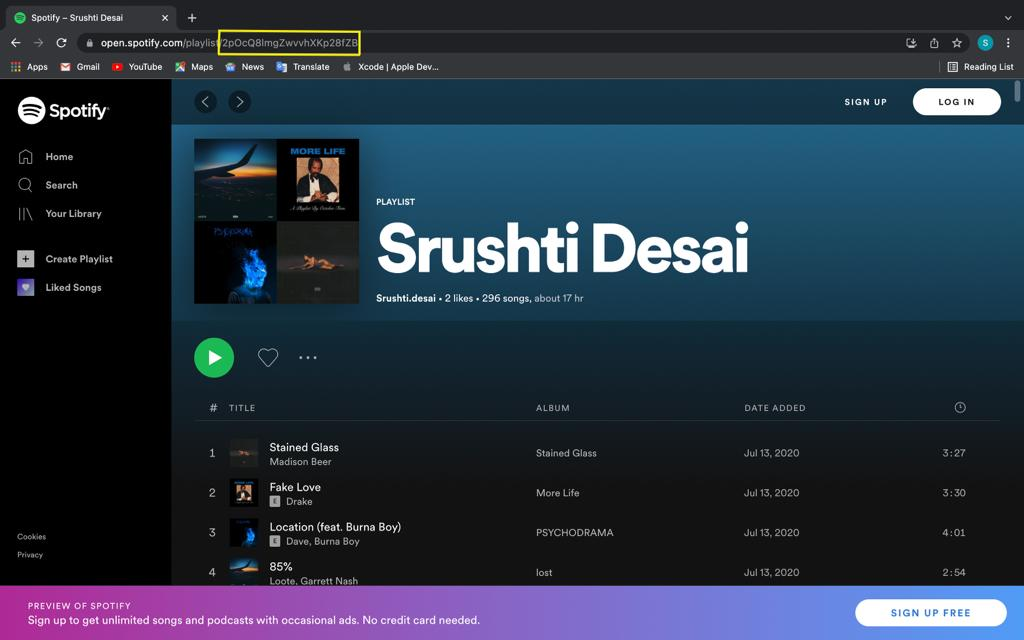

In [61]:
#Calling the function with the URL of the testing playlist.
playlistDF_test = call_playlist("spotify","2pOcQ8lmgZwvvhXKp28fZB")

In [62]:
playlistDF_test.head(40)

,artist,album,track_name,id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Madison Beer,Stained Glass,Stained Glass,0DNtDpmYq7iw7v2RbMdBAy,0.278,0.605,11,-4.972,1,0.0479,0,0.0795,0.130,84.874,207532,4
1,Drake,More Life,Fake Love,343YBumqHu19cGoGARUTsd,0.928,0.481,9,-9.350,0,0.2870,0,0.1760,0.613,134.007,210937,4
2,Dave,PSYCHODRAMA,Location (feat. Burna Boy),3z4CGd63tpUn9a6oQSG0CI,0.812,0.496,9,-5.969,0,0.2970,0,0.0955,0.550,109.979,241293,4
3,Loote,lost,85%,5teOR8KU4XNWY2WlVUDiIR,0.574,0.651,7,-7.585,1,0.0460,0,0.1490,0.368,140.017,174107,4
4,Lil Mosey,Blueberry Faygo,Blueberry Faygo,6wJYhPfqk3KGhHRG76WzOh,0.774,0.554,0,-7.909,1,0.0383,0,0.1320,0.349,99.034,162547,4
5,bülow,Damaged Vol. 2,You & Jennifer,0g21KZ1XJuhwexWPLpuEt1,0.752,0.698,11,-6.530,1,0.3060,0,0.2110,0.347,132.058,159453,4
6,Rihanna,Loud,What's My Name?,5xZtUAVUVfjBtVtMOgMkyy,0.690,0.786,2,-2.959,1,0.0692,0,0.0797,0.583,100.049,263173,4
7,24kGoldn,DROPPED OUTTA COLLEGE,VALENTINO,6piAUJJQFD8oHDUr0b7l7q,0.746,0.717,9,-4.841,0,0.1790,0,0.1320,0.523,150.964,179133,4
8,SAYGRACE,Boys Ain't Shit,Boys Ain't Shit,6vzLbfskWigBsCzNdB0kfE,0.826,0.615,1,-4.729,0,0.1370,0.00631,0.3340,0.841,102.999,175884,4
9,Don Toliver,No Idea,No Idea,3VyjsVV24RmBIbWJAeUJNu,0.651,0.631,6,-5.717,0,0.0896,0.000579,0.1650,0.350,127.994,154424,4


## Extract features
The next step is to generate all the features. We need to first use the id to differentiate songs that are in the playlist and those that are not. Then, we simply add the features for all songs in the playlist together as a summary vector.

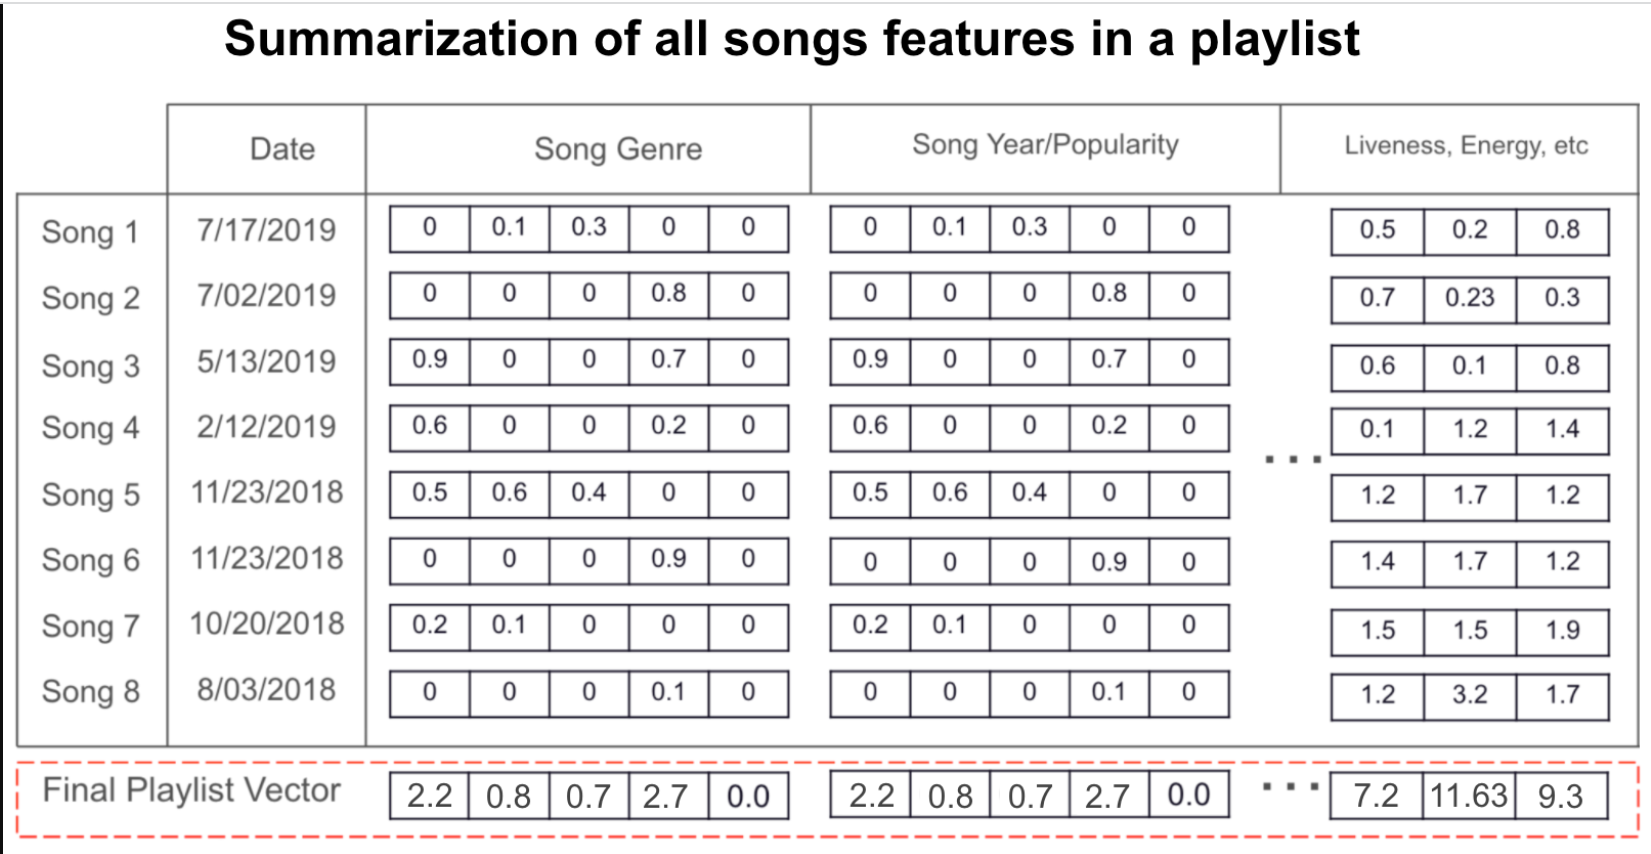

The Final Playlist vector (here it is defined as complete_feature_set_playlist_vector in the below function)  is compared to the vector for every song that is not in the test playlist (here it is Srushti Desai's playlist we choose for testing) 



In [63]:
def generate_playlist_feature(complete_feature_set, playlist_df):
    '''
    Summarize a user's playlist into a single vector
    ---
    Input: 
    complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
    playlist_df (pandas dataframe): playlist dataframe
        
    Output: 
    complete_feature_set_playlist_final (pandas series): single vector feature that summarizes the playlist
    complete_feature_set_nonplaylist (pandas dataframe): 
    '''
    
    # Find song features in the playlist
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]
    # Find all non-playlist song features
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]
    complete_feature_set_playlist_final = complete_feature_set_playlist.drop(columns = "id")
    return complete_feature_set_playlist_final.sum(axis = 0), complete_feature_set_nonplaylist

In [64]:
# Generate the features
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlistDF_test)


In [65]:
# Non-playlist features
complete_feature_set_nonplaylist.head()


genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|accordeon  genre|accordion  genre|acid_house  \
0                     0.0              0.0              0.0               0.0   
1                     0.0              0.0              0.0               0.0   
2                     0.0              0.0              0.0               0.0   
3                     0.0              0.0              0.0               0.0   
4                     0.0              0.0              0.0               0.0   

   genre|acid_rock  genre|acid_trance  genre|acousmatic  genre|acoustic  \
0              0.0                0.0               0.0             0.0   
1              0.0                0.0               0.0             0.0   
2              0.0                0.0               0.0             0.0   
3              0.0                0.0               0.0             0.0   
4              0.0                0.0               0.0             0.0   

   genre|acoustic_blues  genre|acoustic_pop  genre|acoustic_punk  \
0                   0.0                 0.0                  0.0   
1                   0.0                 0.0                  0.0   
2                   0.0                 0.0                  0.0   
3                   0.0                 0.0                  0.0   
4                   0.0                 0.0                  0.0   

   genre|acoustic_rock  genre|action_rock  genre|adoracion  \
0                  0.0                0.0              0.0   
1                  0.0                0.0              0.0   
2                  0.0                0.0              0.0   
3                  0.0                0.0              0.0   
4                  0.0                0.0              0.0   

   genre|adult_standards  genre|adventista  genre|afghan_pop  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               0.0   
4                    0.0               0.0               0.0   

   genre|afghan_traditional  genre|african  genre|african_percussion  \
0                       0.0            0.0                       0.0   
1                       0.0            0.0                       0.0   
2                       0.0            0.0                       0.0   
3                       0.0            0.0                       0.0   
4                       0.0            0.0                       0.0   

   genre|african_reggae  genre|african_rock  genre|afro  genre|afro_dancehall  \
0                   0.0                 0.0         0.0                   0.0   
1                   0.0                 0.0         0.0                   0.0   
2                   0.0                 0.0         0.0                   0.0   
3                   0.0                 0.0         0.0                   0.0   
4                   0.0                 0.0         0.0                   0.0   

   genre|afro_house  genre|afro_psych  genre|afro_soul  genre|afrobeat  \
0               0.0               0.0              0.0             0.0   
1               0.0               0.0              0.0             0.0   
2   

In [66]:
complete_feature_set_playlist_vector.head()


genre|21st_century_classical    0.0
genre|432hz                     0.0
genre|_hip_hop                  0.0
genre|a_cappella                0.0
genre|abstract                  0.0
dtype: float64

In [67]:
#We get only one row for the playlist
complete_feature_set_playlist_vector.shape

(3067,)

## Find similarity and generating recommendations

The Final Playlist vector is compared to the individual song vectors using cosine similarity to generate recommendations.

In our code, we used the cosine_similarity() function from scikit learn to measure the similarity between each song and the summarized playlist vector.

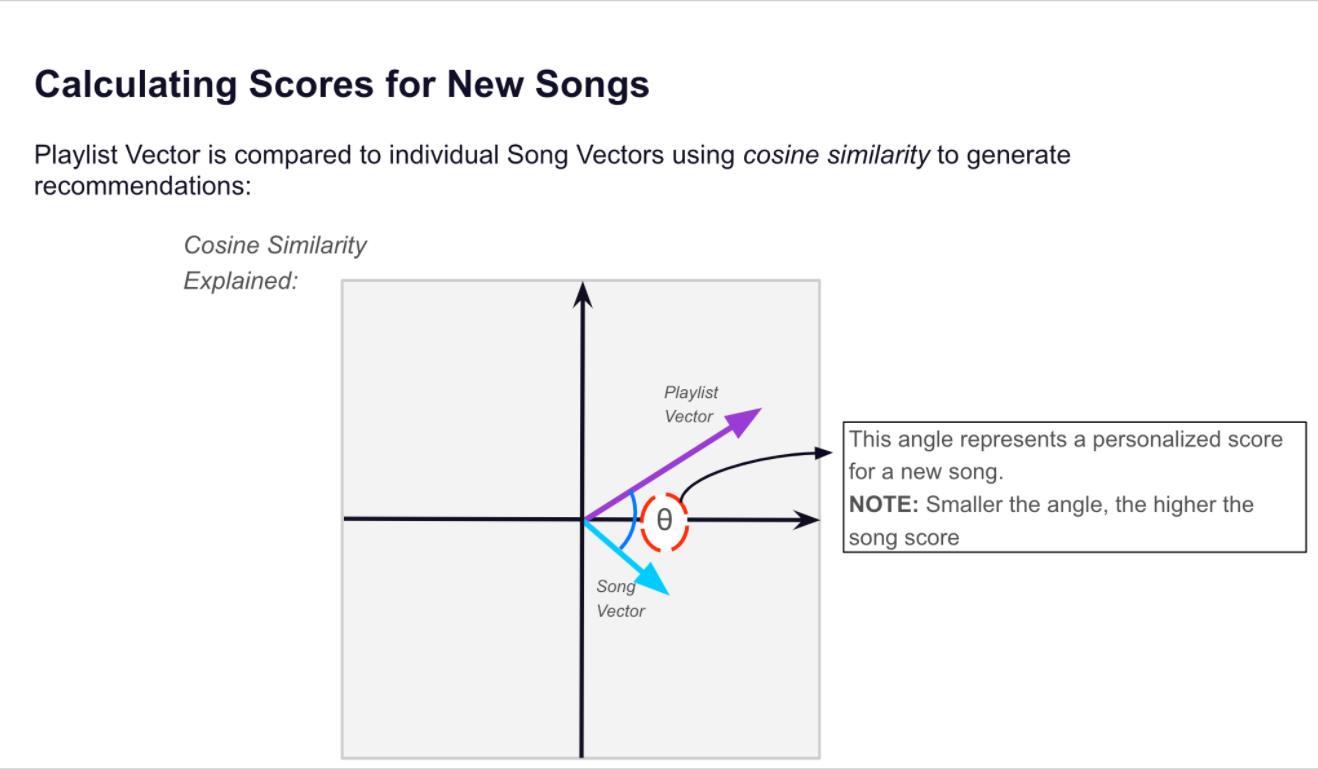




In [68]:
def generate_playlist_recos(df, features, nonplaylist_features):
    '''
    Generated recommendation based on songs in aspecific playlist.
    ---
    Input: 
    df (pandas dataframe): spotify dataframe
    features (pandas series): summarized playlist feature (single vector)
    nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Output: 
    non_playlist_df_top_40: Top 40 recommendations for that playlist
    '''
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    # Find cosine similarity between the playlist and the complete song set
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_100 = non_playlist_df.sort_values('sim',ascending = False).head(100)
    
    return non_playlist_df_top_100


In [69]:
# Genreate top 10 recommendation
recommend = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)
recommend.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,final_genre_lists,popularity_red,sim
23777,0.562,2020,0.0406,['Chloe x Halle'],0.707,157867,0.651,1,0qU3XhIH9xczYPUWV6OopS,0.000006,4,0.449,-3.156,0,Forgive Me,67,2020-06-12,0.0669,137.017,[Chloe x Halle],[],[Chloe x Halle],Chloe x HalleForgive Me,"[post-teen_pop, pop, pop_rap, r&b, pop_dance, ...",13,0.686037
23775,0.553,2020,0.0916,['Chloe x Halle'],0.701,176787,0.668,0,1bRjwdtScY2eMe9uMmsOkG,0.000002,5,0.111,-7.287,0,Do It,70,2020-05-14,0.0516,82.978,[Chloe x Halle],[],[Chloe x Halle],Chloe x HalleDo It,"[post-teen_pop, pop, pop_rap, r&b, pop_dance, ...",14,0.681620
101608,0.300,2018,0.4150,"['Normani', '6LACK']",0.578,215671,0.588,1,2qHk6Nz5glNQrjW8Rhd5kv,0.000000,0,0.114,-4.920,0,Waves (feat. 6LACK),60,2018-11-15,0.2550,79.174,"[Normani, 6LACK]",[],"[Normani, 6LACK]",NormaniWaves (feat. 6LACK),"[post-teen_pop, rap, pop, melodic_rap, pop_rap...",12,0.677597
23844,0.678,2019,0.8730,"['Chris Brown', 'Justin Bieber', 'Ink']",0.660,204880,0.395,0,7ILEWkpfdK6AjH2D7jppWk,0.000000,7,0.112,-5.242,1,Don't Check On Me (feat. Justin Bieber & Ink),68,2019-06-28,0.0333,81.997,"[Chris Brown, Justin Bieber, Ink]",[],"[Chris Brown, Justin Bieber, Ink]",Chris BrownDon't Check On Me (feat. Justin Bie...,"[post-teen_pop, rap, southern_hip_hop, pop, po...",13,0.673173
83571,0.357,2017,0.5690,"['Logic', 'Alessia Cara', 'Khalid']",0.620,250173,0.574,1,5tz69p7tJuGPeMGwNTxYuV,0.000000,5,0.190,-7.788,0,1-800-273-8255,80,2017-05-05,0.0479,100.023,"[Logic, Alessia Cara, Khalid]",[],"[Logic, Alessia Cara, Khalid]",Logic1-800-273-8255,"[post-teen_pop, rap, pop, pop_rap, pop_dance, ...",16,0.669960


In [73]:
playlistDF_test[["artist","track_name"]][:10]

,artist,track_name
0,Madison Beer,Stained Glass
1,Drake,Fake Love
2,Dave,Location (feat. Burna Boy)
3,Loote,85%
4,Lil Mosey,Blueberry Faygo
5,bülow,You & Jennifer
6,Rihanna,What's My Name?
7,24kGoldn,VALENTINO
8,SAYGRACE,Boys Ain't Shit
9,Don Toliver,No Idea


In [70]:
recommend[["artists_upd","name"]][:100]

,artists_upd,name
23777,[Chloe x Halle],Forgive Me
23775,[Chloe x Halle],Do It
101608,"[Normani, 6LACK]",Waves (feat. 6LACK)
23844,"[Chris Brown, Justin Bieber, Ink]",Don't Check On Me (feat. Justin Bieber & Ink)
83571,"[Logic, Alessia Cara, Khalid]",1-800-273-8255
18634,"[Bruno Mars, Cardi B]",Finesse - Remix; feat. Cardi B
66439,"[Jessie Reyez, 6LACK]",Imported (with 6LACK)
64789,"[Jason Derulo, French Montana]",Tip Toe (feat. French Montana)
20640,"[Cardi B, Bruno Mars]",Please Me
75610,"[Katy Perry, Migos]",Bon appétit


## Comparison between the Spotify recommended list and the recommendation we generated using Content based filtering technique

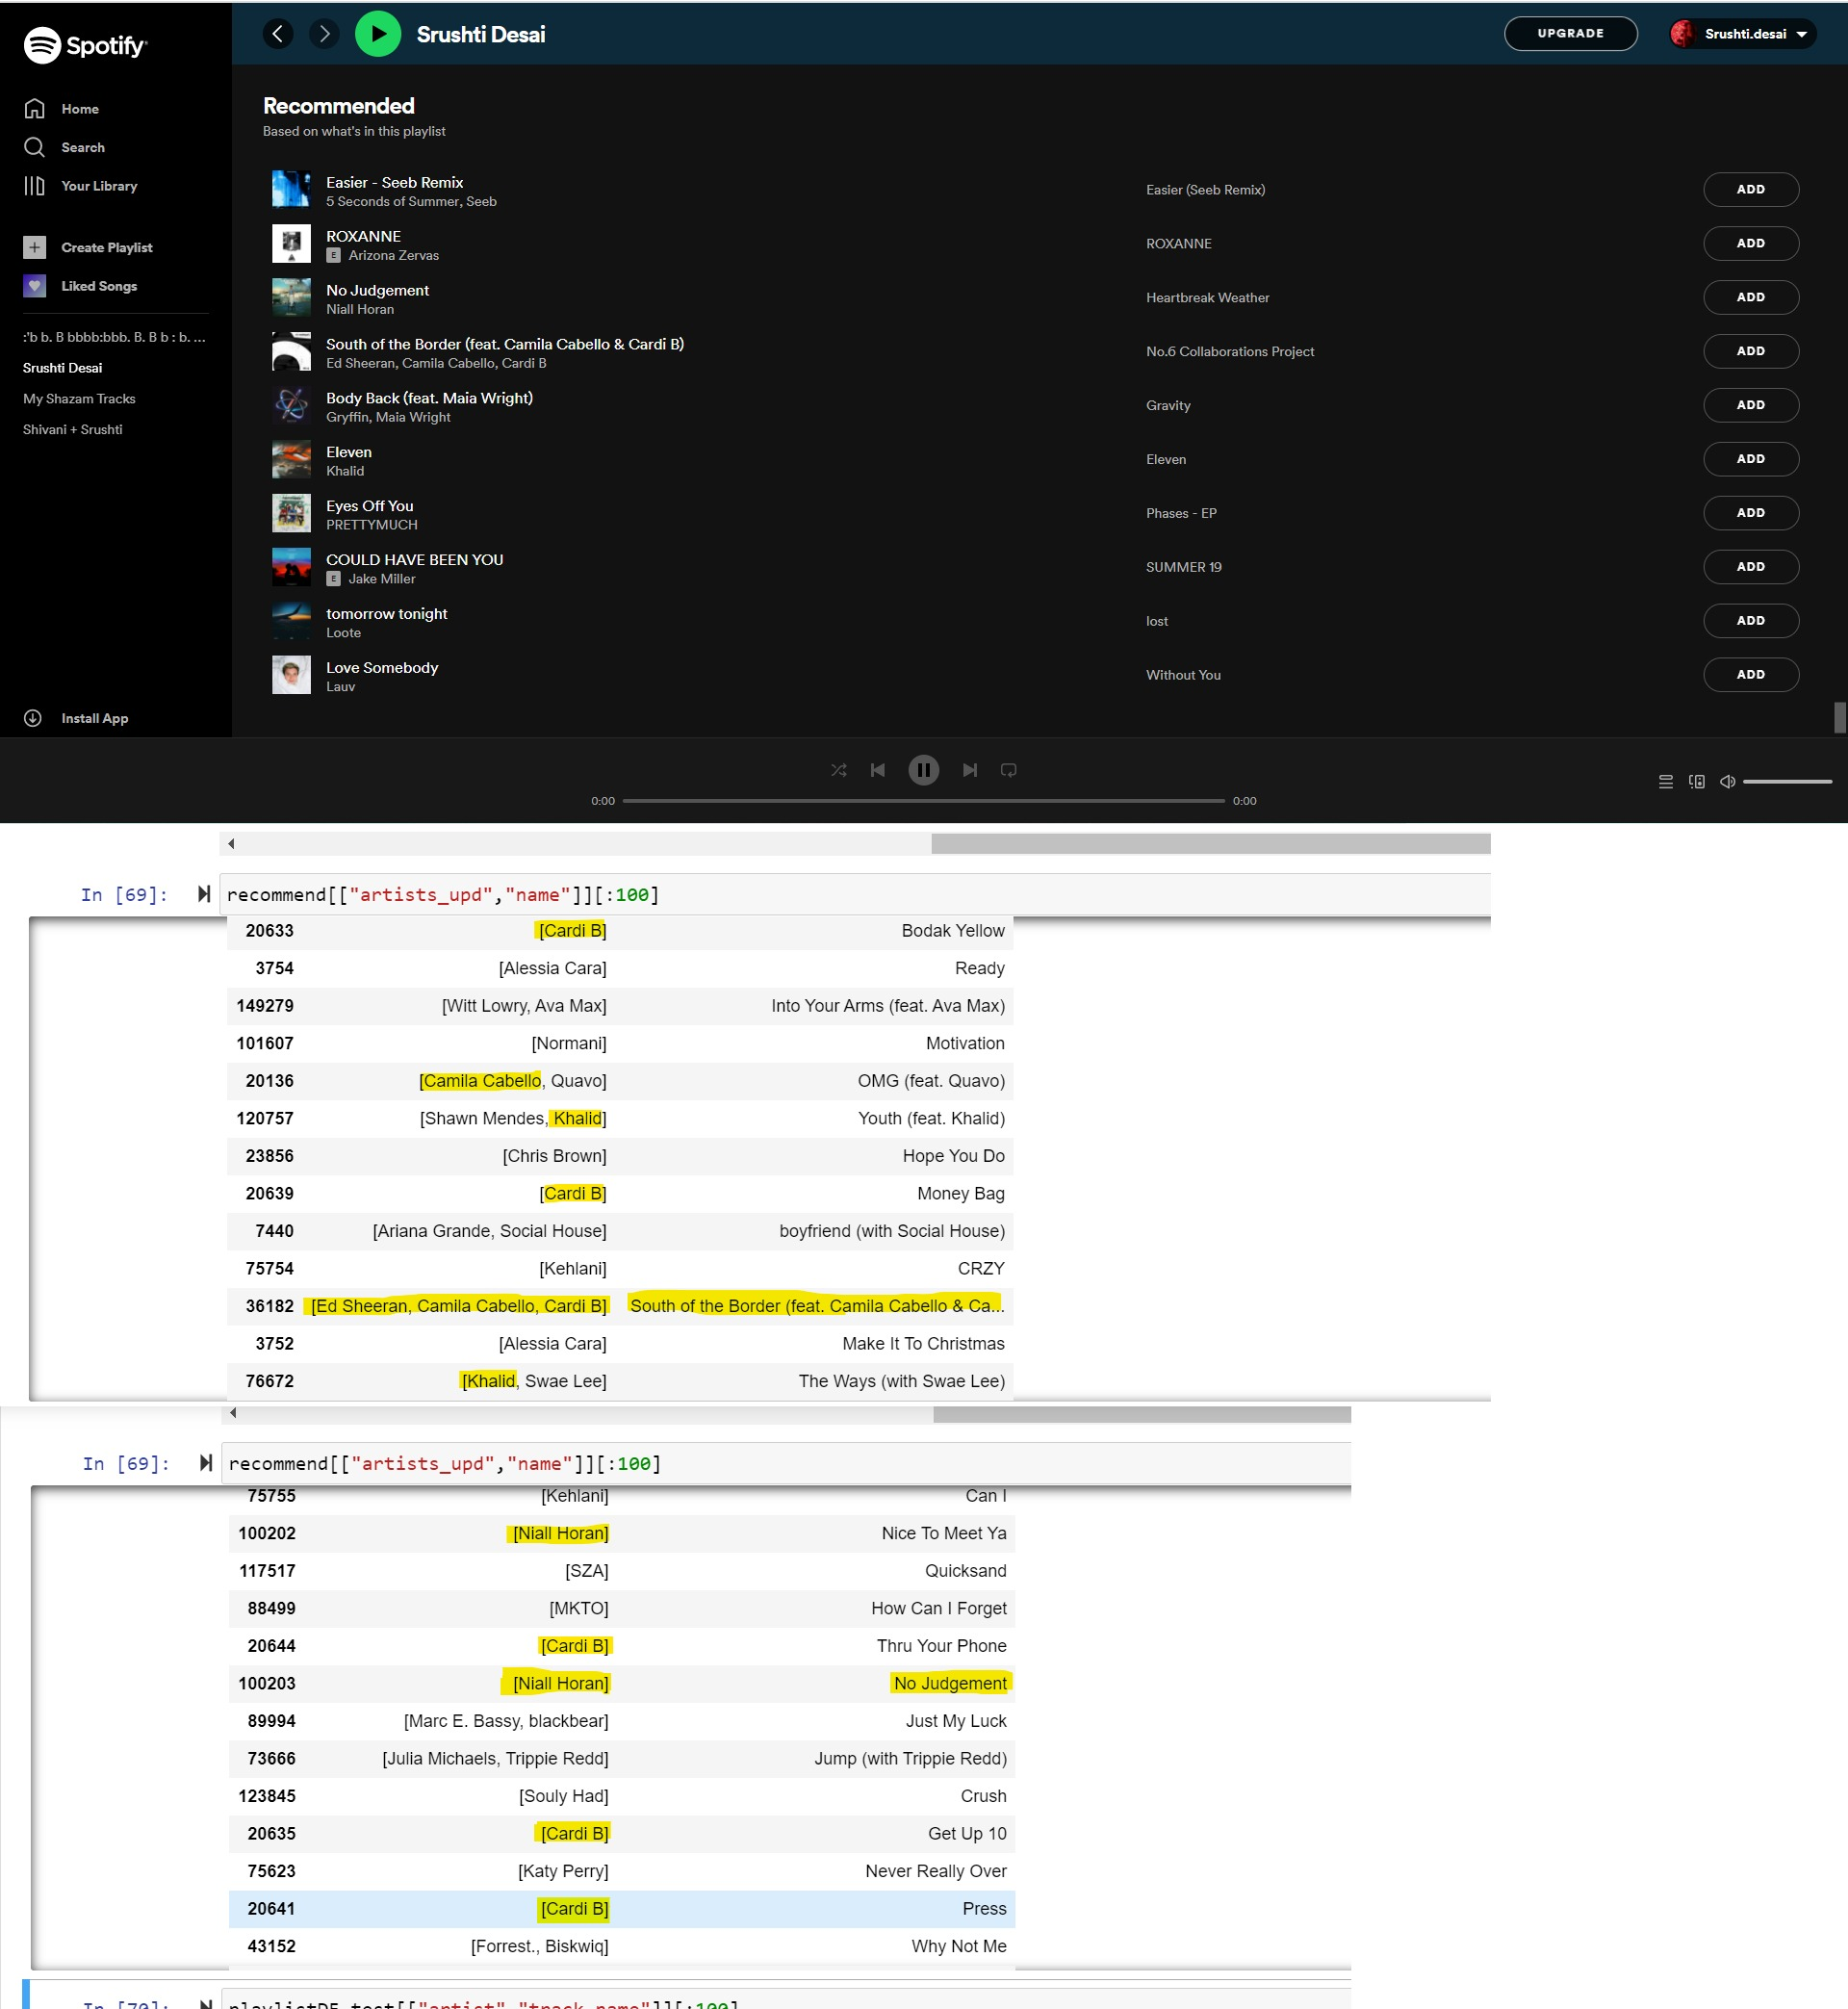


### References:
1. https://www.youtube.com/watch?v=tooddaC14q4
2. https://towardsdatascience.com/part-iii-building-a-song-recommendation-system-with-spotify-cf76b52705e7
3. https://www.linkedin.com/pulse/extracting-your-fav-playlist-info-spotifys-api-samantha-jones